In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False


def set_device():
    device = 'cpu'
    if torch.cuda.device_count() > 0 and torch.cuda.is_available():
        print("Cuda installed! Running on GPU!")
        device = torch.device(torch.cuda.current_device())
        print(f'Device: {device} {torch.cuda.get_device_name(device)}')
    else:
        print("No GPU available!")
    return device

set_seed(100)
device = set_device()

Cuda installed! Running on GPU!
Device: cuda:0 Quadro K2200


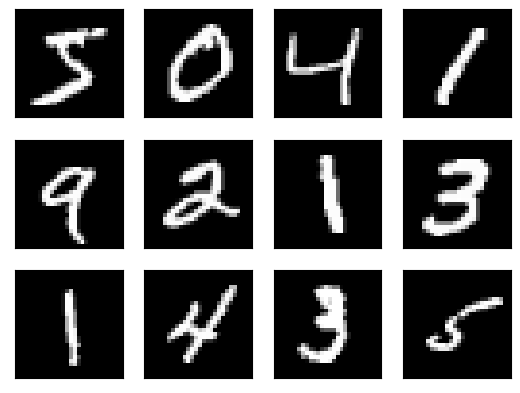

In [116]:
# read MNIST training data
df = pd.read_csv('data/mnist_train.csv')
X = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
y = df.iloc[:, 0].to_numpy()                # labels of images

# write a binary classifier that classifies whether the digit is 5 or not
y_binary = (y == 5).astype(int)

# plot the first dozen images from the data set
plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1, xticks=[], yticks=[])
    image = X[i, :].reshape((28,28))
    plt.imshow(image, cmap='gray')


In [117]:
# convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_binary, dtype=torch.float32)

# make w and b require gradients and be randomly initialized
w_tensor = torch.rand(784, dtype=torch.float32, requires_grad=True)
b_tensor = torch.rand(1, dtype=torch.float32, requires_grad=True)

def model(X, w, b):
    return torch.sigmoid(torch.matmul(X, w) + b)

def loss_fn(y_pred, y):
    eps = 1e-8
    return -torch.mean(y * torch.log(y_pred + eps) + (1 - y) * torch.log(1 - y_pred + eps))

# compute the initial loss function gradient at (w, b) using Pytorch backpropagation
y_pred_tensor = model(X_tensor, w_tensor, b_tensor)
loss = loss_fn(y_pred_tensor, y_tensor)
loss.backward()

# compute the initial loss function gradient at (w, b) mannually
dJ_dw = torch.matmul(model(X_tensor, w_tensor, b_tensor) - y_tensor, X_tensor) / X_tensor.shape[0]
dJ_db = torch.sum(model(X_tensor, w_tensor, b_tensor) - y_tensor) / X_tensor.shape[0]

# compare the two gradients
print("Difference in dJ/dw:", torch.norm(dJ_dw - w_tensor.grad))
print("Difference in dJ/db:", torch.abs(dJ_db - b_tensor.grad))


Difference in dJ/dw: tensor(5.3828, grad_fn=<LinalgVectorNormBackward0>)
Difference in dJ/db: tensor([0.8995], grad_fn=<AbsBackward0>)


In [121]:
# Stochastic Gradient Descent
# using a batch size of b = 32, write a function that returns a stochastic gradient of J by choosing b
# randomly chosen images from the dataset.

def stochastic_gradient(X, y, w, b, batch_size=32):
    indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    X_batch = torch.tensor(X[indices, :], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w.grad = None
    b.grad = None
    y_pred_batch = model(X_batch, w, b)
    loss = loss_fn(y_pred_batch, y_batch)
    loss.backward()
    return w.grad, b.grad 

# test the stochastic gradient function
dJ_dw_sgd, dJ_db_sgd = stochastic_gradient(X_tensor, y_tensor, w_tensor, b_tensor, batch_size=32)
print("Stochastic gradient dJ/dw:", dJ_dw_sgd)
print("Stochastic gradient dJ/db:", dJ_db_sgd)

Stochastic gradient dJ/dw: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.000

/tmp/ipykernel_149823/1626184039.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X[indices, :], dtype=torch.float32)
/tmp/ipykernel_149823/1626184039.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y[indices], dtype=torch.float32)


In [120]:
# compute the full gradient using the entire dataset
def full_gradient(X, y, w, b):
    w.grad = None
    b.grad = None
    y_pred = model(X, w, b)
    loss = loss_fn(y_pred, y)
    loss.backward()
    return w.grad, b.grad

# test the full gradient function
dJ_dw_full, dJ_db_full = full_gradient(X_tensor, y_tensor, w_tensor, b_tensor)

# call the stochastic gradient function multiple times and average the results
num_samples = 100
dJ_dw_avg = torch.zeros_like(w_tensor)
dJ_db_avg = torch.zeros_like(b_tensor)
for _ in range(num_samples):
    dJ_dw_sgd, dJ_db_sgd = stochastic_gradient(X_tensor, y_tensor, w_tensor, b_tensor, batch_size=32)
    dJ_dw_avg += dJ_dw_sgd / num_samples
    dJ_db_avg += dJ_db_sgd / num_samples

# compare the average stochastic gradient with the full gradient
print("Difference in dJ/dw:", torch.norm(dJ_dw_avg - dJ_dw_full))
print("Difference in dJ/db:", torch.abs(dJ_db_avg - dJ_db_full))

Difference in dJ/dw: tensor(0.0054)
Difference in dJ/db: tensor([0.0002])


/tmp/ipykernel_149823/1626184039.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X[indices, :], dtype=torch.float32)
/tmp/ipykernel_149823/1626184039.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y[indices], dtype=torch.float32)
